# Udacity Dermatologist AI Mini Project

## 1.0 Import Libraries

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os
from PIL import Image

# check if CUDA is available
use_cuda = torch.cuda.is_available()

## 2.0 Load and Transform Data

In [2]:
# load filenames for skin lesion images
skin_lesions = np.array(glob("data/*/*/*"))

# print number of images in each dataset
print('There are %d total skin lesion images.' % len(skin_lesions))

There are 2750 total skin lesion images.


In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# set directory for the training, validation, and test dataset
train_dir = "data/train"
valid_dir = "data/valid"
test_dir = "data/test"
batch_size = 30

# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

# add random transformations to the training dataset to enable the model to better generalize
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# perform the necessary image transforms without random transformations for the validation and test datasets
validation_transforms = transforms.Compose([transforms.Resize(256), 
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(), 
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])
    
# Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_image_datasets = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_image_datasets = datasets.ImageFolder(test_dir, transform=validation_transforms)
    
# Using the image datasets and the trainforms, define the dataloaders
train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, shuffle=True)
validation_dataloaders = torch.utils.data.DataLoader(validation_image_datasets, batch_size=batch_size)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size)

# create a loaders_scratch dictionary as required for the downstream model_scratch model
dataloader_dict = {"train": train_dataloaders, "valid":validation_dataloaders, "test":test_dataloaders}

In [4]:
# print out some data stats
print('Number training images: ', len(dataloader_dict["train"].dataset))
print('Number validation images: ', len(dataloader_dict["valid"].dataset))
print('Number test images: ', len(dataloader_dict["test"].dataset))

Number training images:  2000
Number validation images:  150
Number test images:  600


<ipython-input-5-d2823275e61a>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

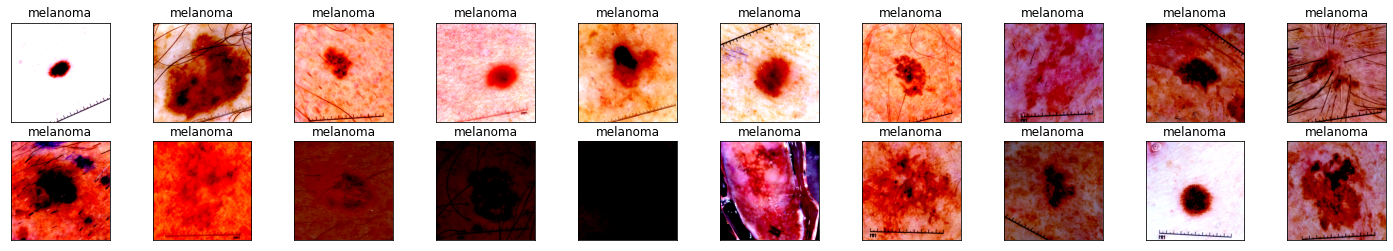

In [5]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(dataloader_dict["valid"])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## 3.0 Define the Model

In [6]:
# Load the pretrained model from pytorch
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# define VGG16 model
model_transfer = models.vgg16(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 3.1 Create Final Classifer Layer

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# freeze the VGG-16 model parameters
for param in model_transfer.parameters():
    param.requires_grad = False

class Transfer_Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.fc1 = nn.Linear(self.input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, self.output_size)
        self.dropout = nn.Dropout(.25)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        
        return x

In [8]:
len(classes)

3

In [9]:
model_transfer.classifier[0].in_features

25088

In [10]:
# identify the total number of features that the VGG-16 network expects the classifier fully connected layer to receive
input_size = model_transfer.classifier[0].in_features
# set total number of image classes
output_size = len(classes)

# replace VGG-16 network classifier with the custom Transfer_Classifer
model_transfer.classifier = Transfer_Classifier(input_size, output_size)

# move tensors to GPU if CUDA is availabe
if use_cuda:
    model_transfer.cuda()

model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 3.2 Train Model

In [11]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_transfer.classifier.parameters(), lr=.009)

In [12]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''
    Trains an image classifier against a training dataset and test against a validation 
    image dataset.  The algorithm saves the best performing model parameter state checkpoint.
    Prints out training and validation loss metrics.
    
    arguments:
        n_epochs: quantity of epoch iteration to train model
        loaders: dictionary of training and validation image tensors
        model: image classifier model
        optimizer: gradient descent optimizer
        criterion: loss function
        use_cuda: cpu or gpu
        save_path: save model's checkpoint
        
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity Deep Learning Nano Degree Training material.
    '''

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear gradients of optimized variables
            optimizer.zero_grad()
            # forward pass:
            output = model(data)
            ## find the loss and update the model parameters accordingly
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased")
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [ ]:
# train the model
n_epochs = 2

model_transfer = train(n_epochs, dataloader_dict, model_transfer, optimizer, criterion, use_cuda, 'model_transfer.pt')

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### 3.3 Test Model

In [46]:
def test(loaders, model, criterion, use_cuda):
    '''
    Tests a model's image classifier against a directory of test images.
    Prints out Test Loss and Accuracy status
    
    arguments:
        loaders: test image tensors
        model: image classifier model
        criterion: loss function
        use_cuda: cpu or gpu
    
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity Deep Learning Nano Degree Training material.
    '''

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
test(dataloader_dict, model_transfer, criterion, use_cuda)

## 4.0 Implementation

In [50]:
def imagenet_preprocess(img_path):
    '''
    Preprocesses the provided image file into a preprocesses, normalized tensor or normalized cuda tensor if available
    
    argument:
        img_path: path to an image
    
    returns:
        normalized tensor of cuda tensor if available
    
    Code Attribution:
        Acquired segments of this code from the Pytorch documentation https://pytorch.org/hub/pytorch_vision_vgg/.
    '''
    # Load and pre-process an image from the given img_path
    image = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    # if gpu is accessible convert image to a cuda tensor
    if use_cuda:
        input_batch = input_batch.cuda()
    return input_batch

In [ ]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in loaders_transfer["train"].dataset.classes]

def predict_skin_lesion(img_path):
    '''
    Use the created transfer learning VGG-16 model to predict and identify the dog breed
    
    Args:
        img_path: path to an image
        
    Returns:
        Dog breed corresponding to VGG-16 model_transfer prediction
    '''
    # load the image and return the predicted breed
    input_batch = imagenet_preprocess(img_path)
    
    output = model_transfer(input_batch)
    
    # breed index of the predicted class for that image
    skin_lesion = torch.nn.functional.softmax(output, dim=1).argmax().item()
    
    # return the predicted dog breed
    return skin_lesion

predict_skin_lesion("data/test/melanoma/ISIC_0012258.jpg")